In [1]:
import sys
import os
import gc
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import torch

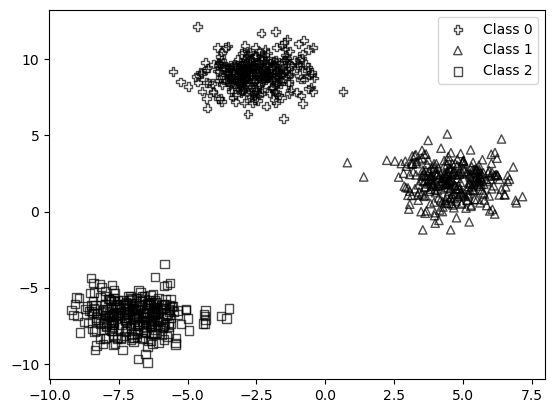

torch.Size([6000, 2]) torch.Size([6000]) torch.Size([900, 2]) torch.Size([900])


Data format: 
--------------------------------
type(train_data.data[0]) -> <class 'torch.Tensor'>
train_data.data[0].dtype -> torch.float32

type(train_data.targets) -> <class 'torch.Tensor'>
train_data.targets.dtype -> torch.int64


Access Data by indexing
--------------------------------
train_data[0] -> (torch.Size([2]), torch.Size([]))


max and min values of train_data.data:
--------------------------------
	[(tensor(-10.8020), tensor(12.9405))]





In [2]:
torch.manual_seed(42)
from SyntheticHelperFunctions_paper.GetStandardData import preprocessed_synthetic_data
train_data, test_data, x_test_for_plotting, y_test_for_plotting = preprocessed_synthetic_data(n_train_samples=6000,
                                                    n_test_samples=900,
                                                    n_features=2,
                                                    n_classes=3,
                                                    random_state=42)

In [3]:
from ZeroHelperFunctions_paper.DataLoadersForZero import DataLoadersForZero
dl = DataLoadersForZero(train_data=train_data,
                    test_data=test_data,
                    data_shape_of_data_point=(2))

In [4]:
BATCH_SIZE = 32
dl.make_dataloaders(batch_size=BATCH_SIZE, 
                    n_train_zeros=6_000, 
                    n_test_zeros=900,
                    label_for_zero=3)

In [5]:
zero_class_data, zero_class_labels = dl.zero_data_for_printing, dl.zero_labels_for_printing
zero_class_data.shape

torch.Size([900, 2])

In [6]:
dl.generate_zero_class_dataloader(n_zeros=6_000,
                                batch_size=BATCH_SIZE,
                                label=10)

In [7]:
torch.manual_seed(42)
from ZeroHelperFunctions_paper.zeroTrainer import ZeroTrainer


In [8]:
from Networks.networks import FullyConnectedNet

In [9]:
NUM_DIMENSIONS = 2
NUM_EPOCHS = 2
learning_rate = 0.005

zero_model = FullyConnectedNet(input_dim=NUM_DIMENSIONS,
                    layer1_dim=NUM_DIMENSIONS * 10,
                    layer2_dim=NUM_DIMENSIONS * 5,
                    layer3_dim=11*10,
                    num_classes=11)

simple_model = FullyConnectedNet(input_dim=NUM_DIMENSIONS,
                    layer1_dim=NUM_DIMENSIONS * 10,
                    layer2_dim=NUM_DIMENSIONS * 5,
                    layer3_dim=11*10,
                    num_classes=10)

In [10]:
# Import PyTorch
import torch
from torch import nn

torch.manual_seed(42)
zero_trainer = ZeroTrainer(model=zero_model,
                        number_of_non_zero_classes=3,
                        train_dl=dl.train0_dataloader,
                        test_dl=dl.test_dataloader,
                        purity_fact_dl=dl.test0_dataloader,
                        zero_dl=dl.zero_dataloader,
                        loss_fn=nn.CrossEntropyLoss(),
                        optimizer=torch.optim.SGD(params=zero_model.parameters(), lr=learning_rate),
                        label_of_zero_class=3,
                        device="cuda" if torch.cuda.is_available() else "cpu",
                        plot_data = dl.combined_test_data,
                        plot_targets = dl.combined_test_targets,
                        zero_exists=1)

simple_trainer = ZeroTrainer(model=simple_model,
                        number_of_non_zero_classes=3,
                        train_dl=dl.train_dataloader,
                        test_dl=dl.test_dataloader,
                        purity_fact_dl=dl.test0_dataloader,
                        zero_dl=dl.zero_dataloader,
                        loss_fn=nn.CrossEntropyLoss(),
                        optimizer=torch.optim.SGD(params=simple_model.parameters(), lr=learning_rate),
                        label_of_zero_class=3,
                        device="cuda" if torch.cuda.is_available() else "cpu",
                        plot_data = dl.combined_test_data,
                        plot_targets = dl.combined_test_targets, 
                        zero_exists = 0)


Training...(epochs: 2)
Epoch: 0
----------------
num_classes 4 True


KeyboardInterrupt: 

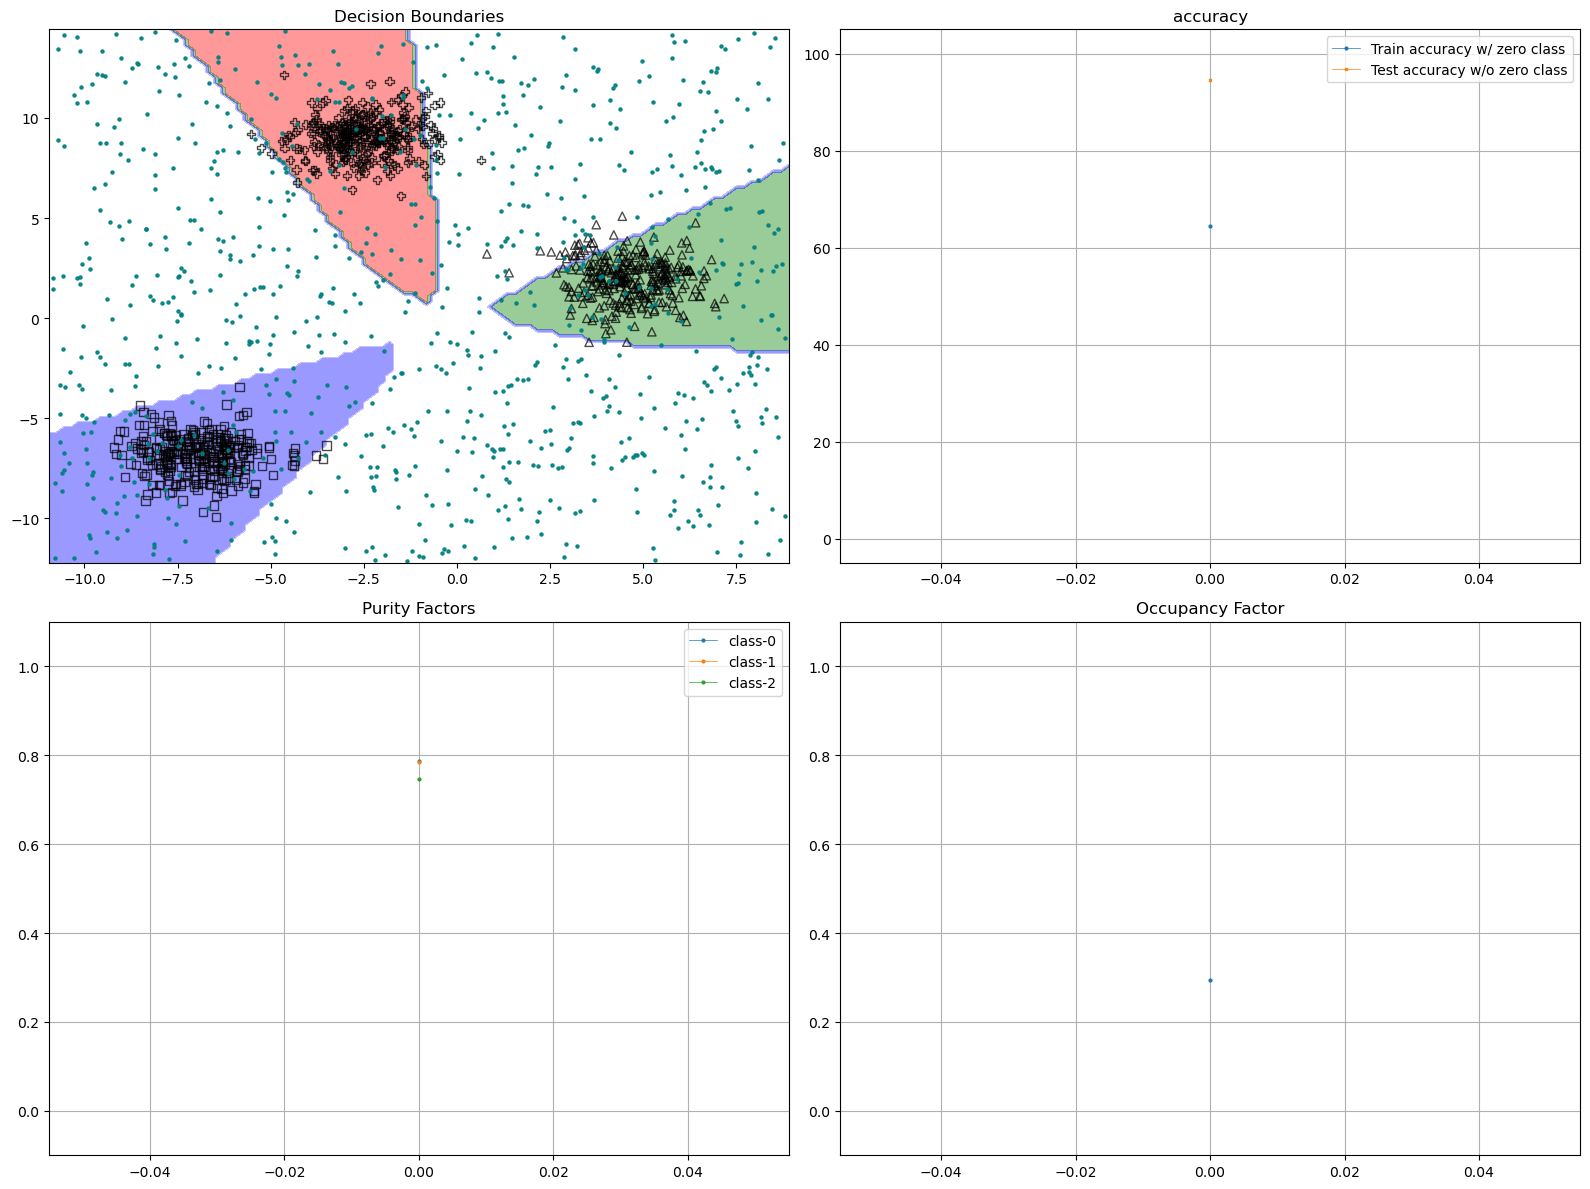

In [11]:
zero_trainer.train(epochs=NUM_EPOCHS)

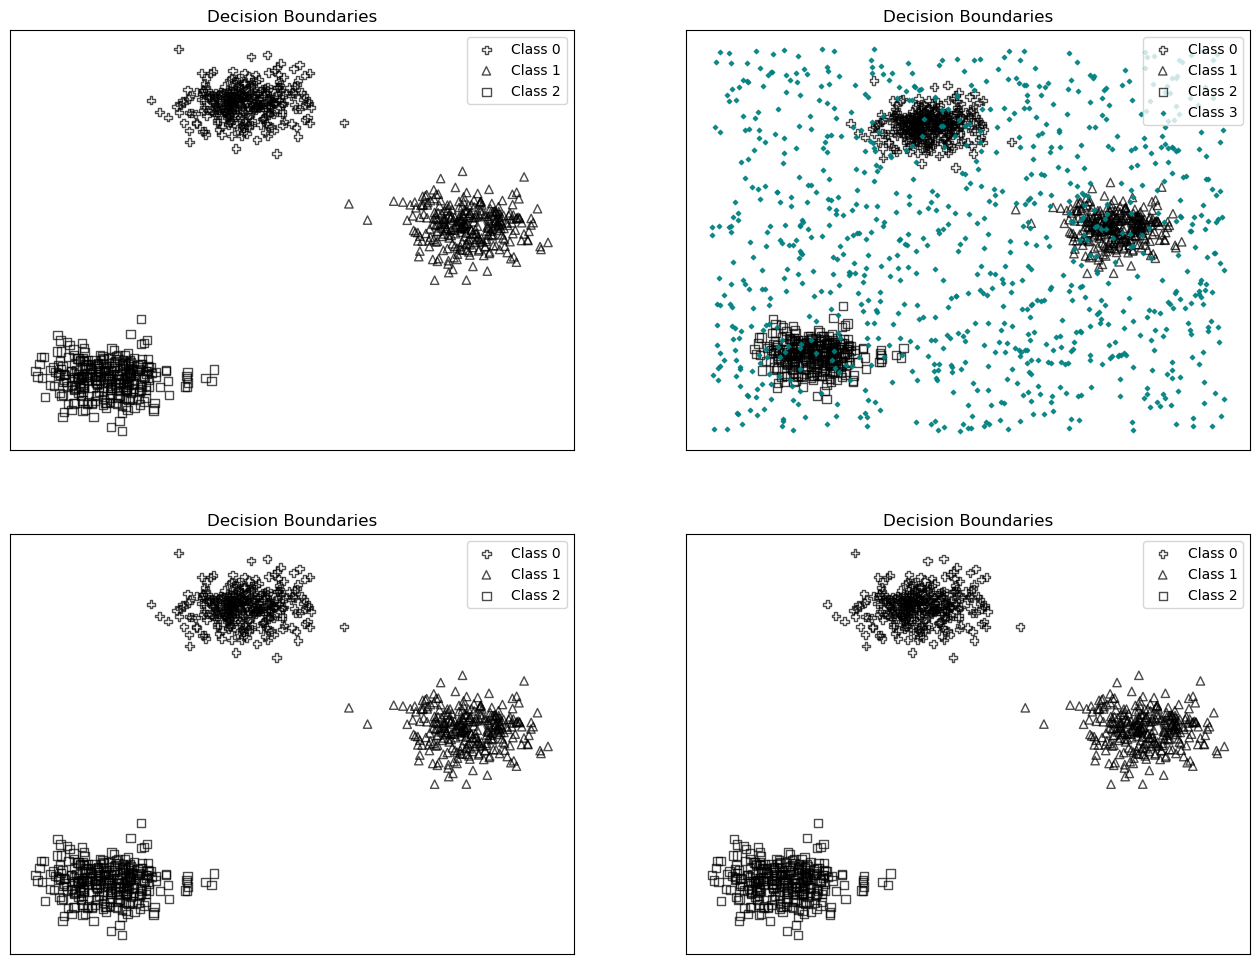

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.title("Decision Boundaries")
markers = ['P', '^', 's', 'D', 'X', '*']  # Add more shapes if needed
for cls in range(3):
    plt.scatter(
        x_test_for_plotting[y_test_for_plotting == cls, 0],  # X-coordinate for class `cls`
        x_test_for_plotting[y_test_for_plotting == cls, 1],  # Y-coordinate for class `cls`
        color='none',  # Uniform color for all points
        label=f'Class {cls}', 
        marker=markers[cls % len(markers)], 
        edgecolor='black',  # Optional: Add edge color for better visibility
        alpha=0.7,  # Optional: Adjust transparency for better visualization
        linewidths=1,
        # s=20,
    )
plt.xticks([])
plt.yticks([])
plt.legend()
plt.subplot(2, 2, 2)
plt.title("Decision Boundaries")
markers = ['P', '^', 's', 'D', 'X', '*']  # Add more shapes if needed
for cls in range(4):
    if cls == 4 - 1:  # Check if it's the last class
        plt.scatter(
            dl.combined_test_data[dl.combined_test_targets == cls, 0],  # X-coordinate for class `cls`
            dl.combined_test_data[dl.combined_test_targets == cls, 1],  # Y-coordinate for class `cls`
            color='#008080',  # Fill color for the last class
            label=f'Class {cls}', 
            marker=markers[cls % len(markers)], 
            edgecolor='#008080',  # Specific edge color for the last class
            alpha=0.9,  # Optional: Different transparency for the last class
            linewidths=1,  # Optional: Thicker edge for better visibility
            s=5
        )
    else:  # For all other classes
        plt.scatter(
            dl.combined_test_data[dl.combined_test_targets == cls, 0],  # X-coordinate for class `cls`
            dl.combined_test_data[dl.combined_test_targets == cls, 1],  # Y-coordinate for class `cls`
            color='none',  # Uniform transparent color
            label=f'Class {cls}', 
            marker=markers[cls % len(markers)], 
            edgecolor='black',  # Black edge for other classes
            alpha=0.7,  # Transparency for other classes
            linewidths=1,
        )
plt.xticks([])
plt.yticks([])
plt.legend()
plt.subplot(2, 2, 3)
plt.title("Decision Boundaries")
markers = ['P', '^', 's', 'D', 'X', '*']  # Add more shapes if needed
for cls in range(3):
    plt.scatter(
        x_test_for_plotting[y_test_for_plotting == cls, 0],  # X-coordinate for class `cls`
        x_test_for_plotting[y_test_for_plotting == cls, 1],  # Y-coordinate for class `cls`
        color='none',  # Uniform color for all points
        label=f'Class {cls}', 
        marker=markers[cls % len(markers)], 
        edgecolor='black',  # Optional: Add edge color for better visibility
        alpha=0.7,  # Optional: Adjust transparency for better visualization
        linewidths=1,
        # s=20,
    )
plt.xticks([])
plt.yticks([])
plt.legend()
plt.subplot(2, 2, 4)
plt.title("Decision Boundaries")
markers = ['P', '^', 's', 'D', 'X', '*']  # Add more shapes if needed
for cls in range(3):
    plt.scatter(
        x_test_for_plotting[y_test_for_plotting == cls, 0],  # X-coordinate for class `cls`
        x_test_for_plotting[y_test_for_plotting == cls, 1],  # Y-coordinate for class `cls`
        color='none',  # Uniform color for all points
        label=f'Class {cls}', 
        marker=markers[cls % len(markers)], 
        edgecolor='black',  # Optional: Add edge color for better visibility
        alpha=0.7,  # Optional: Adjust transparency for better visualization
        linewidths=1,
        # s=20,
    )
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [13]:
from ZeroHelperFunctions_paper import plots

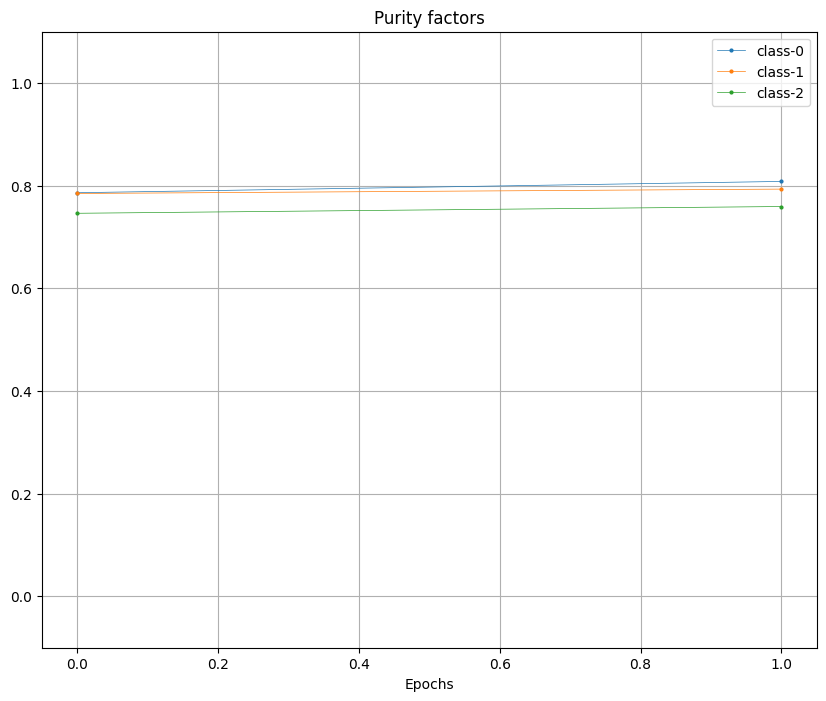

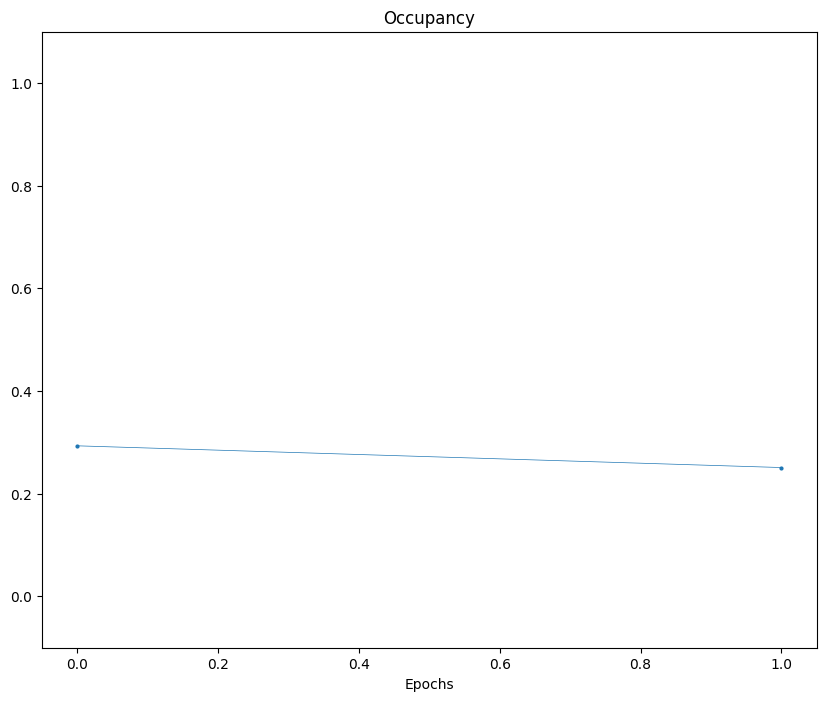

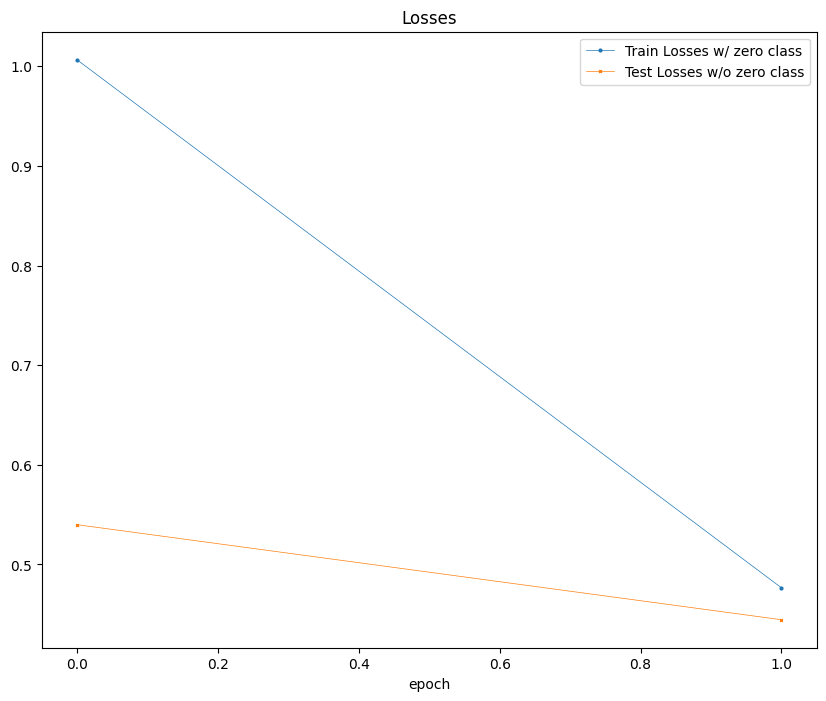

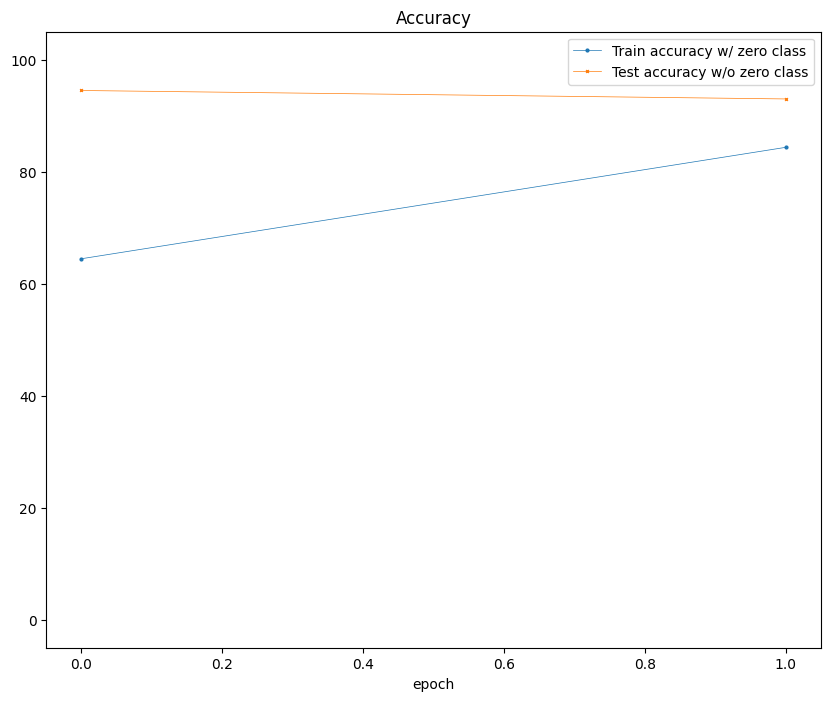

In [14]:
plots.plot_pf(zero_trainer.purities)
plots.plot_of(zero_trainer.occupancy)
plots.plot_train_test_losses(zero_trainer.train_loss,
                             zero_trainer.test_loss)
plots.plot_train_test_accs(zero_trainer.train_acc,
                           zero_trainer.test_acc)

In [15]:
simple_trainer.train(epochs=NUM_EPOCHS,
                    image_dir="test_images")

Training...(epochs: 2)
Epoch: 0
----------------
num_classes 3 False
no zero? 
Epoch: 1
----------------


KeyboardInterrupt: 

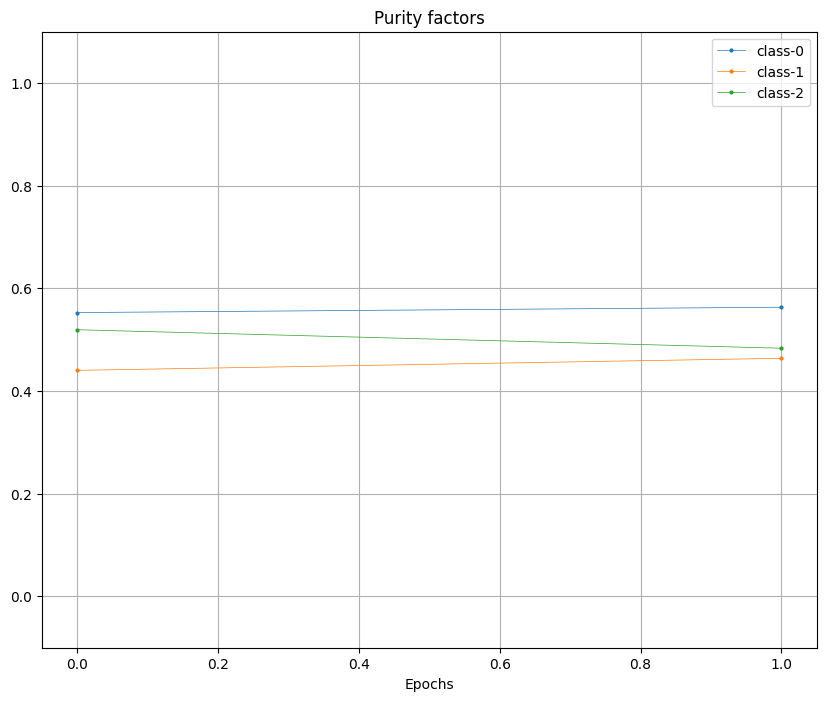

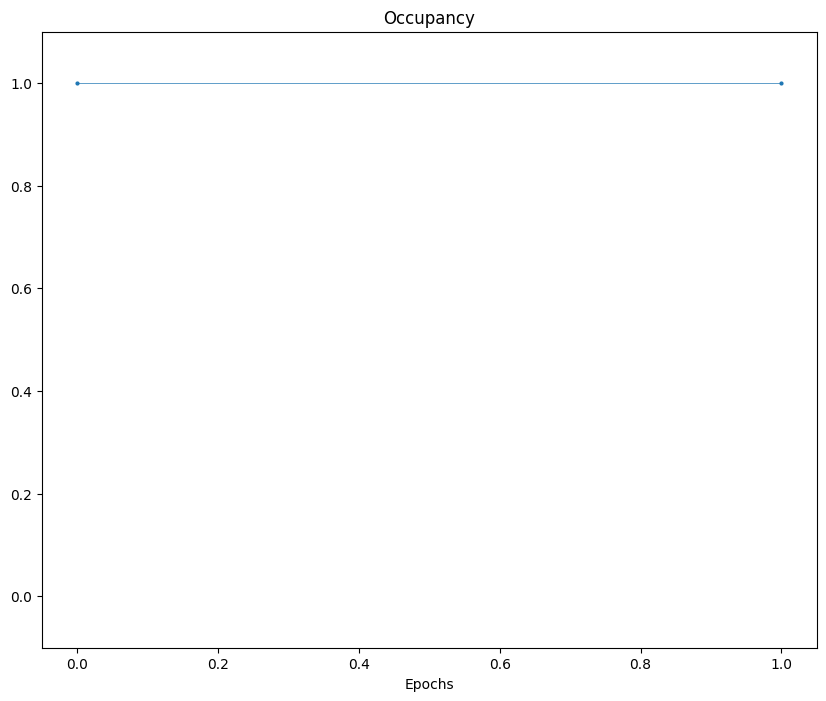

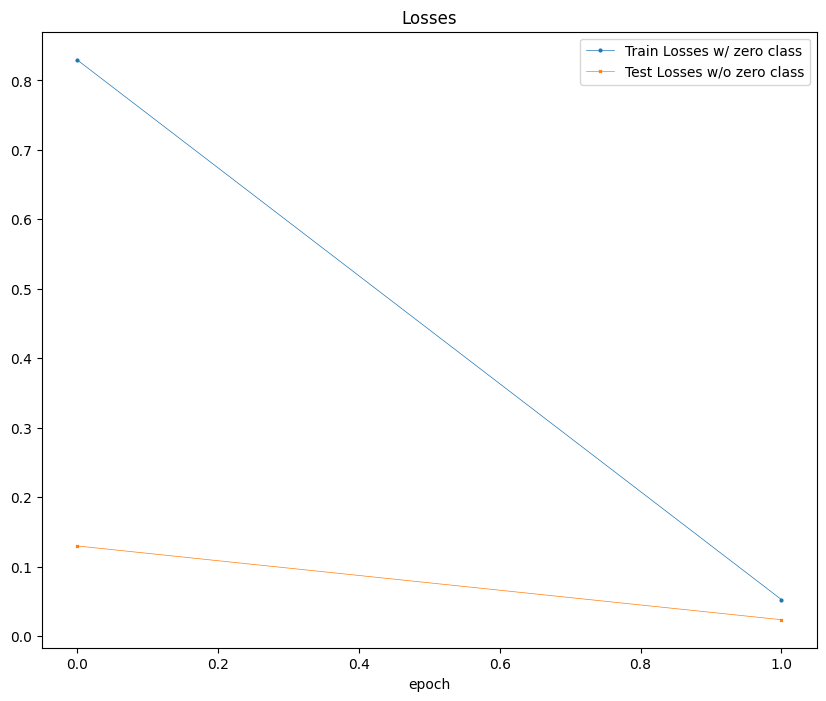

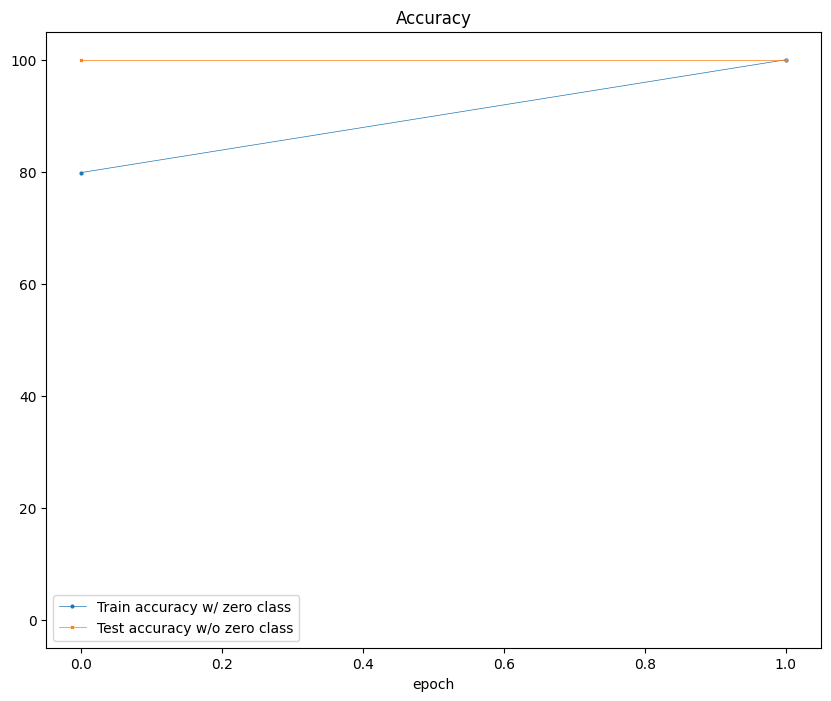

In [ ]:
plots.plot_pf(simple_trainer.purities)
plots.plot_of(simple_trainer.occupancy)
plots.plot_train_test_losses(simple_trainer.train_loss, simple_trainer.test_loss)
plots.plot_train_test_accs(simple_trainer.train_acc, simple_trainer.test_acc)

In [24]:
from ZeroHelperFunctions_paper.helper_functions import plot_decision_boundary, plot_decision_boundary_non_zero

wtf 0
wtf 1
wtf 2
wtf 3
we are in
no zero? 
wtf 0
wtf 1
wtf 2
wtf 3
we are in


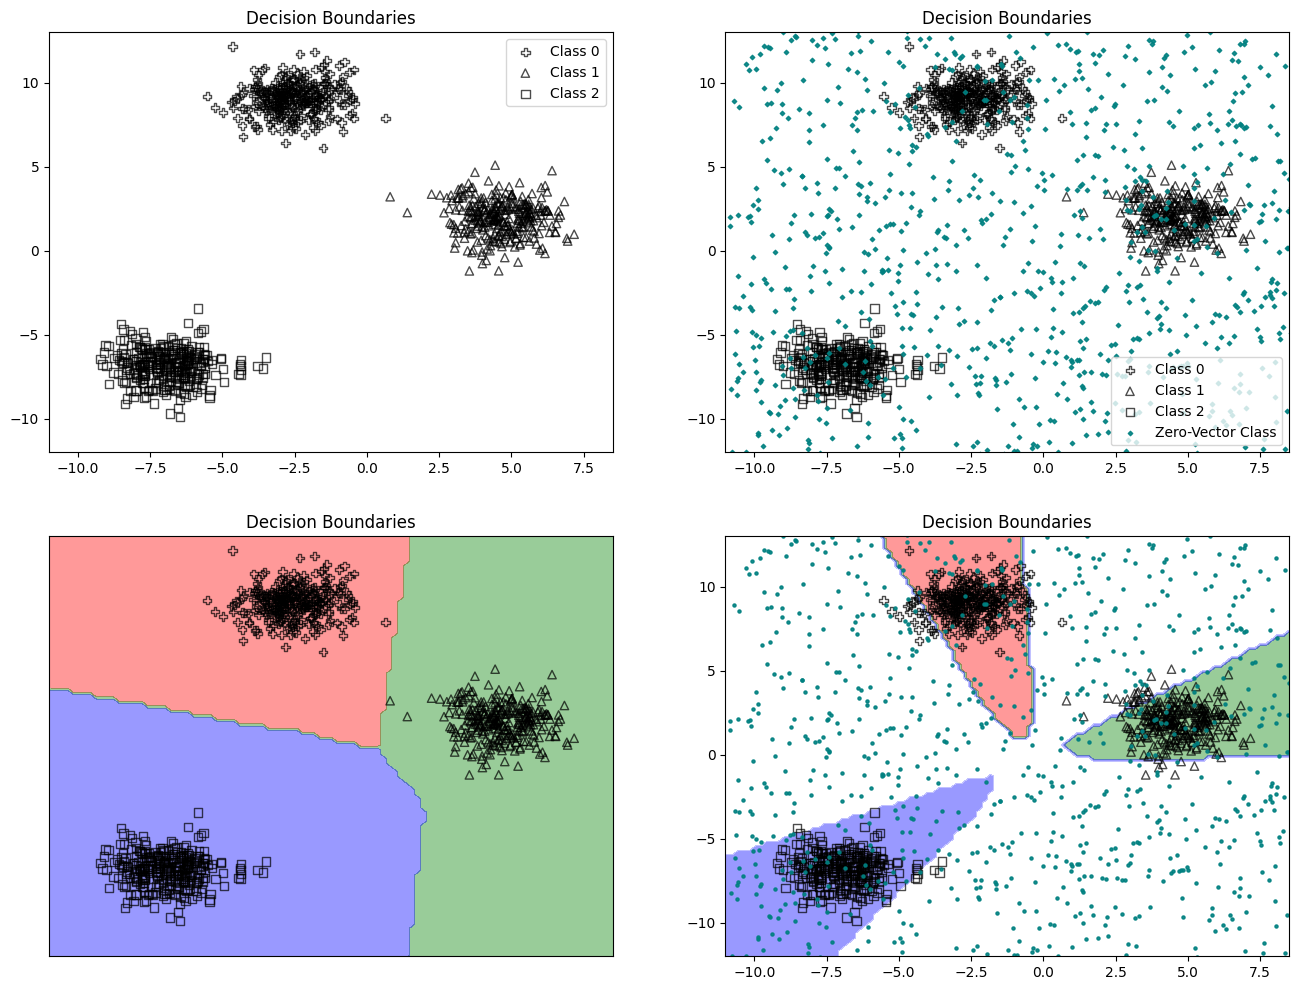

In [25]:
import matplotlib.pyplot as plt
x_range = (-11, 8.5)
y_range = (-12, 13)
fig = plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.title("Decision Boundaries")
markers = ['P', '^', 's', 'D', 'X', '*']  # Add more shapes if needed
for cls in range(3):
    plt.scatter(
        x_test_for_plotting[y_test_for_plotting == cls, 0],  # X-coordinate for class `cls`
        x_test_for_plotting[y_test_for_plotting == cls, 1],  # Y-coordinate for class `cls`
        color='none',  # Uniform color for all points
        label=f'Class {cls}', 
        marker=markers[cls % len(markers)], 
        edgecolor='black',  # Optional: Add edge color for better visibility
        alpha=0.7,  # Optional: Adjust transparency for better visualization
        linewidths=1,
        # s=20,
    )
# plt.xticks([])
# plt.yticks([])
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend()
plt.subplot(2, 2, 2)
plt.title("Decision Boundaries")
markers = ['P', '^', 's', 'D', 'X', '*']  # Add more shapes if needed
for cls in range(4):
    print("wtf", cls)
    if cls == 4 - 1:  # Check if it's the last class
        print("we are in")
        plt.scatter(
            dl.combined_test_data[dl.combined_test_targets == cls, 0],  # X-coordinate for class `cls`
            dl.combined_test_data[dl.combined_test_targets == cls, 1],  # Y-coordinate for class `cls`
            color='#008080',  # Fill color for the last class
            label=f'Zero-Vector Class', 
            marker=markers[cls % len(markers)], 
            edgecolor='#008080',  # Specific edge color for the last class
            alpha=0.9,  # Optional: Different transparency for the last class
            linewidths=1,  # Optional: Thicker edge for better visibility
            s=5
        )
    else:  # For all other classes
        plt.scatter(
            dl.combined_test_data[dl.combined_test_targets == cls, 0],  # X-coordinate for class `cls`
            dl.combined_test_data[dl.combined_test_targets == cls, 1],  # Y-coordinate for class `cls`
            color='none',  # Uniform transparent color
            label=f'Class {cls}', 
            marker=markers[cls % len(markers)], 
            edgecolor='black',  # Black edge for other classes
            alpha=0.7,  # Transparency for other classes
            linewidths=1,
        )
# plt.xticks([])
# plt.yticks([])
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend()
plt.subplot(2, 2, 3)
plt.title("Decision Boundaries")
plot_decision_boundary_non_zero(simple_model, dl.combined_test_data, dl.combined_test_targets, n_classes=3)
plt.xlim(x_range)
plt.ylim(y_range)
plt.subplot(2, 2, 4)
plt.title("Decision Boundaries")
plot_decision_boundary(zero_model, dl.combined_test_data, dl.combined_test_targets, n_classes=4)
plt.xlim(x_range)
plt.ylim(y_range)
plt.show()

In [ ]:
plot_decision_boundary(zero_model, dl.combined_test_data, dl.combined_test_targets)


TypeError: plot_decision_boundary() missing 1 required positional argument: 'n_classes'